#    Data 620, Project 1  

#### Team 6: Alice Friedman, Jun Pan, Stephen (Scott) Jones, and Jeff Littlejohn  

#### June 19, 2019  

#### Presentation Link: https://vimeo.com/342767483

## Introduction
Candidates, parties, journalists, and a steadily increasing share of the public are using Twitter to comment on, interact around, and research public reactions to politics (Jungheer 2016). Use of Twitter can be modeled as a network in several ways: Users can be described as nodes and edges can be described as they follow, reply and mention one another. These connections are visible in the text of each tweet or by requesting lists of the users that follow the author of each tweet from Twitter. Additionally, Tweets themselves can be nodes that are linked to each other in a chain of retweets. Users are tagged with a variety of categorial data including language, location, and verfication status.

A recent feature by Jamie Lauren Keiles in the New York Times Magazine, (Are These Teenagers Really Running a Presidential Campaign? Yes. (Maybe.)”), describes the unorthodox strategy of presidential hopeful and former Senator Mike Gravel, who has turned his social media campaign over to a pair of teenagers. Teenagers are more active than other age groups by accessing social media tools such as Twitter, Facebook and Instagram, but are much less likely to vote than older Americans (especially since by definition most of them aren't old enough!).

<center><img src='mikegravel.png'/><b>@mikegravel</b></center>

We propose to investigate the network of users who retweet Mike Gravel's official campaign account in order to ascertain whether his strategy is reaching political influencers.

Twitter data is available through as JSON through a tiered API. Free versions of the API provide a sample of Tweets available for the last week.

Althought retweets provide a more robust model for a social network, acquiring followship data on Twitter is considerably less complex. Therefore, we will model the network with [@mikegravel](https://twitter.com/mikegravel) as the ego, a sample of his followers, and a sample of his followers' followers.

## Part 1: Import packages

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import urllib.request, json 
from twython import Twython
import time

## Part 2: Data Scraping

The following scripts were run the week of June 9 to access the Twitter API. Because calls are rate limited and credetials must be secured, data was then loaded into JSON files and shared via git.

Due to limitations on the Twitter API free-tier, this data will pull a sample of all followership rather than a full picture. This may impact the analysis, althought code developed for this sample would work on a larger dataset as well. 

### Scrape followers of ego

In [ ]:
# Code below adapated from: https://stackabuse.com/accessing-the-twitter-api-with-python/
# Load Twitter API credentials from json file
with open("twitter_credentials.json", "r") as file:  
    creds = json.load(file)

# Instantiate an object and provide Twitter credentials
twitter = Twython(creds['CONSUMER_KEY'], creds['CONSUMER_SECRET_KEY'], creds['ACCESS_TOKEN'], creds['ACCESS_SECRET_TOKEN'])

# create empty dictionary to accept data
dict_fol = {'screen_name': [], 'verified': [], 'followers_count': []}  

# we don't want to dump directly to the graph because we'll get a giant hairball
# we will want to filter for users with more followers before moving to depth=2 of the social network

#create loop to page through API results
next_cursor = -1

while(next_cursor):
    get_followers = twitter.get_followers_list(screen_name='mikegravel', cursor=next_cursor)
    for user in get_followers['users']:  
        dict_fol['screen_name'].append(user['screen_name'])
        dict_fol['verified'].append(user['verified'])
        dict_fol['followers_count'].append(user['followers_count'])
        time.sleep(75) # avoids running into the API rate limit, which accepts 15 calls every 15 minutes
        
# due to rate limits, have saved a sample of the results into a json file for later reloading
with open("mikegravel_followers.json", "w") as file:  
    json.dump(dict_fol, file)

### Define a function to scrape data for multiple accounts
Having proved the concept, we will know develop a function to loop through a list of @mikegravel's followers to obtain the second-level follower lists. How does this script work?

1. First, we instantiate a Twython object, which we call "twitter"--this is basically a vehicle for telling Twitter that we have credentials to access the API.

2. Next, we create an empty dictionary with the fields we are looking to connect

3. Then, we creat a loop to page through the API results and add them to our dictionary. This is really the key part of the function. 

4. Last, we dump the data into a JSON file. One reason to do it this way is so that we aren't eating up all of our memory by holding all the results in different data forms. Every time the function runs, we are overwriting the dictionary.

In [3]:
def get_followers_json(username):
    try:
        # Load Twitter API credentials from json file
        with open("twitter_credentials.json", "r") as file:  
            creds = json.load(file)

        # 1) Instantiate an object and provide Twitter credentials
        twitter = Twython(creds['CONSUMER_KEY'], creds['CONSUMER_SECRET_KEY'], creds['ACCESS_TOKEN'], creds['ACCESS_SECRET_TOKEN'])# create empty dictionary to accept data
        
        # 2) Create empty dictionary
        dict_fol = {'screen_name': [], 'verified': [], 'followers_count': []}  
    
        # 3) Create loop to page through API results
        next_cursor = -1
        timeout = time.time() + 60*60 #creates a hard end time for the script to run

        while(next_cursor):
            if time.time() > timeout:
                break #ends loop after timeout period
            get_followers = twitter.get_followers_list(screen_name = username, count=1000, cursor=next_cursor)
            print("Getting %s's followers" % username)
            for user in get_followers['users']:  
                dict_fol['screen_name'].append(user['screen_name'])
                dict_fol['verified'].append(user['verified'])
                dict_fol['followers_count'].append(user['followers_count'])
            try: 
                time.sleep(65)
                next_cursor = get_followers["next_cursor"]
            except:
                break #this lets us save progress if we run into a timeout mid-data stream

        # 4) write data to file
        filename=username + "_followers.json"
    
        with open(filename, "w") as file:
            json.dump(dict_fol, file)
        
        print("Saving %s's followers to JSON file" % username)
    
    except: #in case it doesn't work, this prints a message to tell us the script is still running
        i = 15
        while i > 0:
            print("Waiting for API rate limit to reset. Will try again in %d minutes" % i)
            time.sleep(60) #Twitter API rate limits reset after 15 minutes
            i -= 1
        get_followers_json(username) #then it will try again

### Get list to run through

Using the JSON file previously obtained, we can now create a list of top followers to use as the input for our function.

In [7]:
#get list of followers to try to get followers of

head = "https://raw.githubusercontent.com/aliceafriedman/Data620/master/Project1data/"
username = 'mikegravel'
tail = "_followers.json"
url = head + username + tail

with urllib.request.urlopen(url) as url:
    mg_fol_json = json.loads(url.read().decode())   

#turn into pandas dataframe
df_followers = pd.DataFrame(mg_fol_json)
df_followers.sort_values(by='followers_count', inplace=True, ascending=False)
df_followers = df_followers[df_followers.followers_count >500]
df_followers = df_followers.drop_duplicates()

followers_to_get = df_followers['screen_name'].unique()


### Run through list to acquire remaining data

Lastly, we apply our function to the list to acquire our remaining data.

Note: Due to rate limits, this code is not run in this Jupyter notebook.

In [8]:
#run through list of followers to get followers of
for follower in followers_to_get:
    get_followers_json(follower)

Waiting for API rate limit to reset. Will try again in 15 minutes


KeyboardInterrupt: 

## Part 3: Load Data from Files

After all data was scraped from the Twitter API and output to files, we can create a new function to load and clean the scaped data. 

This can be done with a function because all the files are stored in a systematic way.

### Create function to load files

In [3]:
def convert_to_df(username):
    # get url from github (works because file names are systematic)              
    head = "https://raw.githubusercontent.com/aliceafriedman/Data620/master/Project1data/"
    tail = "_followers.json"
    url = head + username + tail
    print(url)
    
    # open url
    with urllib.request.urlopen(url) as url:
         dict_followers = json.loads(url.read().decode())   

    #turn into pandas dataframe
    df_followers = pd.DataFrame.from_dict(dict_followers)
    df_followers.sort_values(by='followers_count', inplace=True, ascending=False)
    df_followers = df_followers[df_followers.followers_count >500]
    df_followers = df_followers.drop_duplicates()

    #add column to show follow
    df_followers['source'] = username
    df_followers['screen_name'] = df_followers['screen_name'].str.lower()

    print("Head of converted dataframe for %s\n" % username)
    print(df_followers[:5])
    print("\n")

    return df_followers



### Generate list of followers to get
Now, we can run the function over all of our data to create dataframes for each user. But which followers should we get? We will create a list from our original dataframe, and work through as many as we can, from most to least followers before we hit the final API rate limit. 

Note: This is the same list we generated above when scraping the Twitter API.

In [4]:
df_followers = convert_to_df('mikegravel')
followers_to_get = df_followers['screen_name'].unique()[:17] #due to rate limit constraints, 
#we were able to actually get the top 17 followers data, only

followers_to_get.sort()

print(followers_to_get) 

https://raw.githubusercontent.com/aliceafriedman/Data620/master/Project1data/mikegravel_followers.json
Head of converted dataframe for mikegravel

        screen_name  verified  followers_count      source
1084        tankcat      True             5183  mikegravel
474         tankcat      True             5182  mikegravel
638     abigail1963     False             4272  mikegravel
964    adomgetachew     False             2654  mikegravel
848   acttogetherfl     False             2381  mikegravel


['abigail1963' 'acttogetherfl' 'adomgetachew' 'ajfeather' 'goddessmasha'
 'helloise7' 'jarongubernick' 'kateah' 'kimfinnie' 'lazybastid'
 'oshiserves' 'politicutie' 'robyn459' 'tankcat' 'thesecondgoing'
 'tucsonmike' 'zacharywelliott']


### Run loop over list to create master dataframe

Using a "for" loop, we can quickly download, convert, and lightly clean all the JSON files into one "master" dataframe. 

In [5]:
master = pd.DataFrame()
for follower in followers_to_get:
    frame = convert_to_df(follower)
    master = master.append(frame)

https://raw.githubusercontent.com/aliceafriedman/Data620/master/Project1data/abigail1963_followers.json
Head of converted dataframe for abigail1963

         screen_name  verified  followers_count       source
371      cooperativa      True          2694253  abigail1963
193     amandapalmer      True          1082703  abigail1963
740          911well     False           631243  abigail1963
831  high_on_glitter     False           615026  abigail1963
860     bella__angel     False           609247  abigail1963


https://raw.githubusercontent.com/aliceafriedman/Data620/master/Project1data/acttogetherfl_followers.json
Head of converted dataframe for acttogetherfl

         screen_name  verified  followers_count         source
261    whatstrending      True           870298  acttogetherfl
645        iraqesque     False           679472  acttogetherfl
946         meldmann     False           599417  acttogetherfl
542  chaelmontgomery     False           430357  acttogetherfl
660     alicema

Head of converted dataframe for zacharywelliott

         screen_name  verified  followers_count           source
384         j4ckmull      True           520689  zacharywelliott
1        pascalguyon      True           502448  zacharywelliott
232      briandevans      True           463161  zacharywelliott
36   chaelmontgomery     False           430358  zacharywelliott
89        georg_grey     False           365476  zacharywelliott




In [6]:
frames = [master,df_followers]# add mikegravel's followers to the follower data

master = pd.concat(frames)

### Remove duplicates and sort

In [7]:
#deduplicate, keeping the record containing the largest follower count

dedup = pd.DataFrame(master)
dedup.sort_values(by=['screen_name','followers_count'], ascending=[True,False], inplace = True) 
dedup.drop_duplicates(subset="screen_name", keep='first', inplace = True)
dedup.head(15)
dedup.tail(15)

screen_name  verified  followers_count           source
936     zombiecirc     False             2618   jarongubernick
197      zoogerdee     False            21015   jarongubernick
541       zookmann      True            58582         robyn459
251       zornbree     False             2595    acttogetherfl
189         zote63     False             1234           kateah
722       zsmokeyz     False            23840  zacharywelliott
235         ztoesq     False             1522      politicutie
754  ztotheotothee     False              544       oshiserves
900      ztsamudzi     False            64213     adomgetachew
526    zulmahawaii     False             1551     goddessmasha
459     zunguzungu     False            16053     adomgetachew
489       zuristar     False            56476       tucsonmike
328   zwanelungele     False             1654   jarongubernick
391         zynr07     False             5884        helloise7
276          zyx_1     False              901         robyn459

### Check for missing (known) connections
Because we are working with a sample of data, we need to check @mikegravel's follower list for connections of each follower we've profiled.

In [8]:
#check for connectivity; clementine is missing
from pandas import DataFrame
answer = dedup.loc[(dedup['screen_name'] == "mslizclementine") | (dedup['screen_name'] == "tankcat") |
                     (dedup['screen_name'] == "oshiserves") | (dedup['screen_name'] == "acttogetherfl") | 
                    (dedup['screen_name'] == "adomgetachew") | (dedup['screen_name'] == "kateah") | 
                    (dedup['screen_name'] == "thesecondgoing") | (dedup['screen_name'] == "tucsonmike") | 
                    (dedup['screen_name'] == "zacharywelliott") | (dedup['screen_name'] == "abigail1963") | 
                  (dedup['screen_name'] == "ajfeather") | (dedup['screen_name'] == "goddessmasha") | 
                   (dedup['screen_name'] == "helloise7") | (dedup['screen_name'] == "jarongubernick") | 
                   (dedup['screen_name'] == "kimfinnie") | (dedup['screen_name'] == "lazybastid") | 
                  (dedup['screen_name'] == "robyn459") | (dedup['screen_name'] == "politicutie")]

print(answer)

          screen_name  verified  followers_count      source
638       abigail1963     False             4272  mikegravel
848     acttogetherfl     False             2381  mikegravel
964      adomgetachew     False             2654  mikegravel
352         ajfeather     False             1542  mikegravel
88       goddessmasha     False             1030  mikegravel
647         helloise7     False             1015  mikegravel
715    jarongubernick     False              995  mikegravel
48             kateah     False             1625  mikegravel
1039        kimfinnie     False             1097  mikegravel
947        lazybastid     False             1523  mikegravel
1067       oshiserves     False              929  mikegravel
138       politicutie     False              939  mikegravel
862          robyn459     False             1009  mikegravel
1084          tankcat      True             5183  mikegravel
478    thesecondgoing     False             2013  mikegravel
518        tucsonmike   

Add mslizclementine as a follower of gravel; her current follower count is 5 and she is not a verified user. Then check again for connections of each follower we've profiled; we're looking to see if mslizclementine is added.

In [9]:
isource = "mikegravel"
iscreen_name = "mslizclementine"
ifollowers_count = 5
iverified = False

dedup = dedup.append(pd.DataFrame([[iscreen_name,iverified,ifollowers_count,isource]], columns
=dedup.columns))

Check again for connections of each follower we've profiled.

In [10]:
answer = dedup.loc[(dedup['screen_name'] == "mslizclementine") | (dedup['screen_name'] == "tankcat") |
                     (dedup['screen_name'] == "dedup") | (dedup['screen_name'] == "acttogetherfl") | 
                    (dedup['screen_name'] == "adomgetachew") | (dedup['screen_name'] == "kateah") | 
                    (dedup['screen_name'] == "thesecondgoing") | (dedup['screen_name'] == "tucsonmike") | 
                    (dedup['screen_name'] == "zacharywelliott") | (dedup['screen_name'] == "abigail1963") | 
                  (dedup['screen_name'] == "ajfeather") | (dedup['screen_name'] == "goddessmasha") | 
                   (dedup['screen_name'] == "helloise7") | (dedup['screen_name'] == "jarongubernick") | 
                   (dedup['screen_name'] == "kimfinnie") | (dedup['screen_name'] == "lazybastid") | 
                  (dedup['screen_name'] == "robyn459") | (dedup['screen_name'] == "politicutie") | 
                  (dedup['screen_name'] == "oshiserves")]

print(answer)

          screen_name  verified  followers_count      source
638       abigail1963     False             4272  mikegravel
848     acttogetherfl     False             2381  mikegravel
964      adomgetachew     False             2654  mikegravel
352         ajfeather     False             1542  mikegravel
88       goddessmasha     False             1030  mikegravel
647         helloise7     False             1015  mikegravel
715    jarongubernick     False              995  mikegravel
48             kateah     False             1625  mikegravel
1039        kimfinnie     False             1097  mikegravel
947        lazybastid     False             1523  mikegravel
1067       oshiserves     False              929  mikegravel
138       politicutie     False              939  mikegravel
862          robyn459     False             1009  mikegravel
1084          tankcat      True             5183  mikegravel
478    thesecondgoing     False             2013  mikegravel
518        tucsonmike   

Now that all followers are included, calculate the log of the follower count to compress the scale, masking those records with value of 0.

In [11]:
#calculate the log of the follower count to compress the scale, masking those records with value of 0.
mask = (dedup['followers_count'] != 0)
dedup_valid = dedup[mask]

dedup['log_fc'] = 0
dedup.loc[mask, 'log_fc'] = np.log(dedup_valid['followers_count'])

In [12]:
#remove those with fewer than 3 followers
master1=dedup.loc[dedup['followers_count'] > 3]

#sort before reindexing
master1 = master1.sort_values(by=['followers_count'])

master1.reset_index(inplace=True)

#delete extra obselete index of each separate dataframe
del master1['index']

print(master1)

          screen_name  verified  followers_count          source     log_fc
0     mslizclementine     False                5      mikegravel   1.609438
1        bosnaireland     False              501  thesecondgoing   6.216606
2       nymediacritic     False              501          kateah   6.216606
3           hollis517     False              501   acttogetherfl   6.216606
4      dennisbright12     False              501       ajfeather   6.216606
5         dmarkscohen     False              501      mikegravel   6.216606
6     vonnegutterball     False              501     politicutie   6.216606
7         nelson_nec_     False              502       ajfeather   6.218600
8     jessicaxnuaghty     False              502      oshiserves   6.218600
9          astrodan13     False              502     abigail1963   6.218600
10          nfl_agent     False              502      tucsonmike   6.218600
11         aron_cowen     False              503         tankcat   6.220590
12      inte

## Plot Data

Now we can use NetworkX to create a graph, and matplotlib to plot it. We will use color to show the status (verified or unverified) of each node. In a second plot, we will use color to show the number of followers.

In [135]:
#read graph frpmo data frame
G=nx.from_pandas_edgelist(master1, 'source', 'screen_name')

#set node attributes use within plot
nx.set_node_attributes(G, pd.Series(master1.followers_count.values, index=master1.screen_name).to_dict(), 'followers_count')
nx.set_node_attributes(G, pd.Series(master1.verified.values, index=master1.screen_name).to_dict(), 'verified')
nx.set_node_attributes(G, pd.Series(master1.log_fc.values, index=master1.screen_name).to_dict(), 'log_fc')

degree=G.degree()
nodes=G.nodes()

#n_color will set color of nodes to degree; each degree in this network is 1.
n_color=np.asarray([degree[n] for n in nodes])

#follow will set the node_color to the log of the follower count for each user.
follow = np.asarray([G.nodes(data='log_fc', default=0)[n] for n in nodes])

#there are very few verified followers; 'verify' may be used as node_color to highlight them.
verify = np.asarray([G.nodes(data='verified', default=0)[n] for n in nodes])

#fix node positioning within spring_layout
fixed_nodes = [n for n in G.nodes()]

#set parameters for the layout
pos = nx.spring_layout(G,weight = 'log_fc', k =.05)

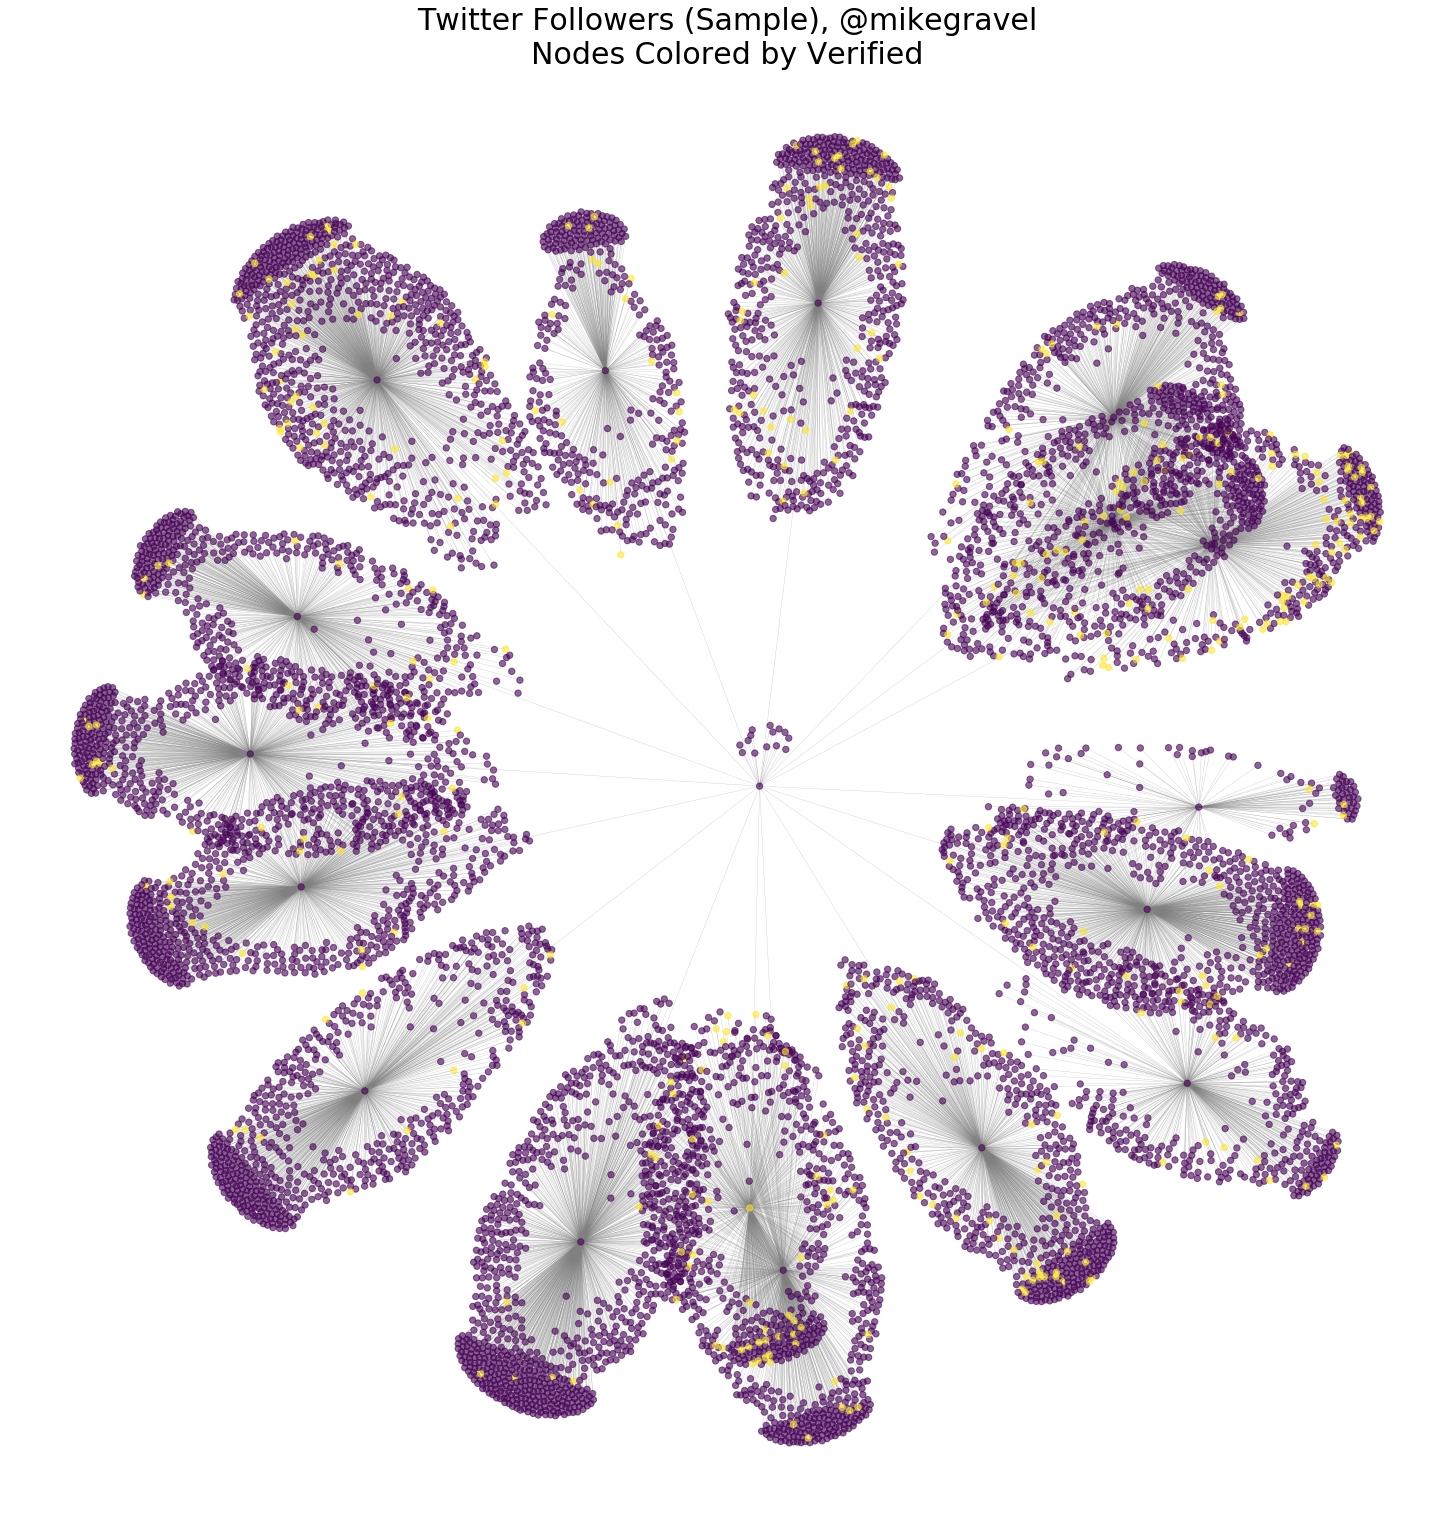

In [136]:
#stop the deprecated message generated by Matplotlib
import warnings
from matplotlib.cbook.deprecation import MatplotlibDeprecationWarning

warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

#make the figure larger
fig = plt.figure(figsize=(20,20))

#plot
nx.draw(G,
        pos,
        node_color=verify,
        with_labels = False, 
        node_size=40,
        edge_color='gray', 
        font_size= 12,
        font_color='black',
        cmap='viridis',
        width=.25,
        alpha = .6)

#nx.draw_networkx_edge_labels(G, pos)
plt.title('Twitter Followers (Sample), @mikegravel\nNodes Colored by Verified',fontsize=30)
plt.show()


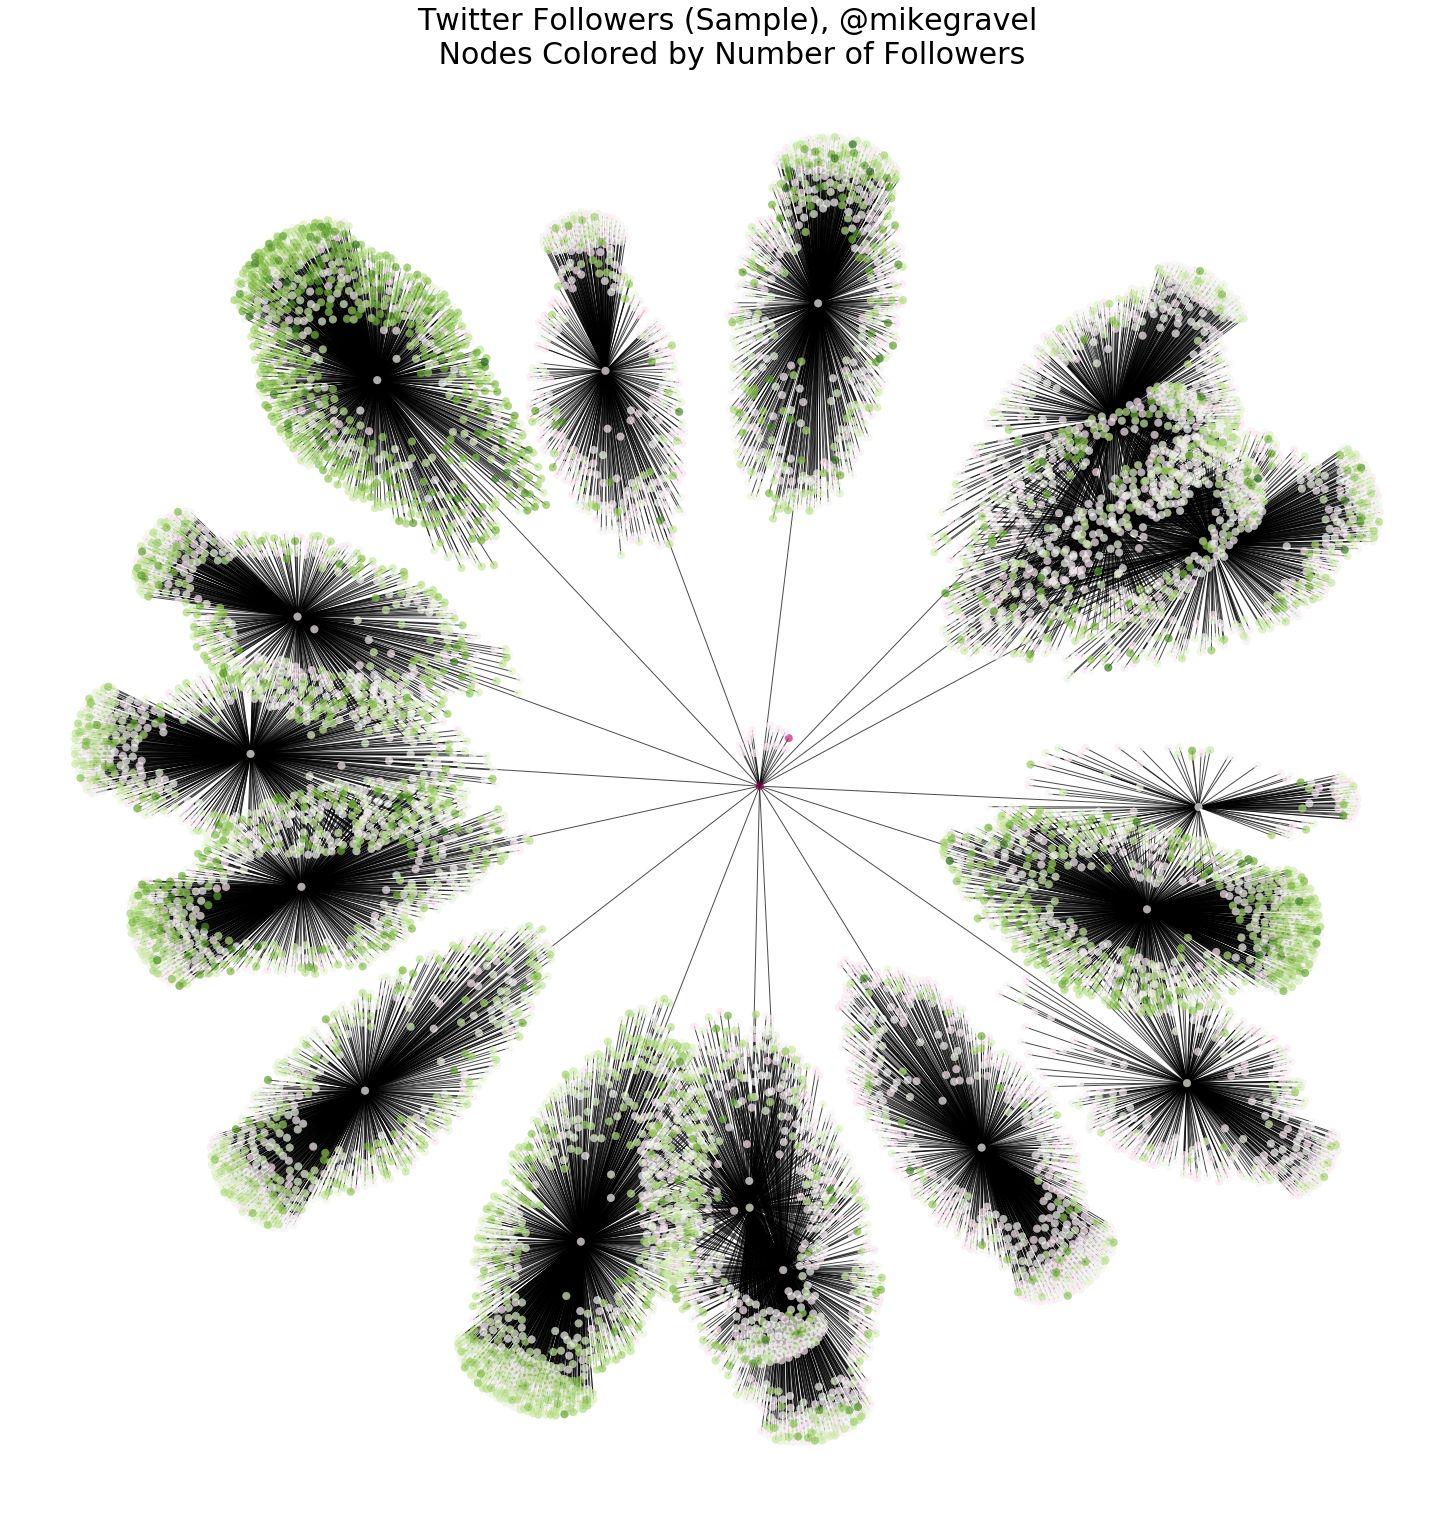

In [137]:
#different plot
plt.figure(figsize = (20,20))
nx.draw(G, 
        pos=pos, 
        node_color=follow, 
        cmap=plt.cm.PiYG, 
        edge_color="black", 
        linewidths=0.3, 
        node_size=60, 
        alpha=0.7, 
        with_labels=False)
plt.title('Twitter Followers (Sample), @mikegravel\n Nodes Colored by Number of Followers',fontsize=30)
plt.savefig('graphfinal.png')
plt.show()

## Centrality Analysis

For the analysis, we find the top 10 users as measured by various measures of centrality.

### Betweenness

In [138]:
G_dict1 = dict(nx.betweenness_centrality(G))
ordered_G = sorted(G_dict1, key = G_dict1.get,reverse = True)

print("Top 10, betweenness centrality:")

for i in range(10):
    print(ordered_G[i])
    
print("\n")

Top 10, betweenness centrality:
mikegravel
helloise7
tucsonmike
robyn459
kimfinnie
thesecondgoing
ajfeather
zacharywelliott
acttogetherfl
goddessmasha




In [139]:
between = pd.DataFrame(G_dict1,index=['between']).T
#print(['%s %0.2f'%(node,between[node]) for node in between])

nodeinfo = pd.DataFrame([i[1] for i in G.nodes(data=True)], index=[i[0] for i in G.nodes(data=True)])

nodeinfo = nodeinfo.merge(between, left_index=True, right_index=True, how='inner')

nodeinfo.head(15)

followers_count    log_fc verified   between
mikegravel                   NaN       NaN      NaN  0.935391
mslizclementine              5.0  1.609438    False  0.000000
thesecondgoing            2013.0  7.607381    False  0.128935
bosnaireland               501.0  6.216606    False  0.000000
kateah                    1625.0  7.393263    False  0.103900
nymediacritic              501.0  6.216606    False  0.000000
acttogetherfl             2381.0  7.775276    False  0.120827
hollis517                  501.0  6.216606    False  0.000000
ajfeather                 1542.0  7.340836    False  0.127751
dennisbright12             501.0  6.216606    False  0.000000
dmarkscohen                501.0  6.216606    False  0.000000
politicutie                939.0  6.844815    False  0.078712
vonnegutterball            501.0  6.216606    False  0.000000
nelson_nec_                502.0  6.218600    False  0.000000
oshiserves                 929.0  6.834109    False  0.099893

### Degree

In [140]:
G_dict2 = dict(nx.degree_centrality(G))
ordered_G2 = sorted(G_dict2, key = G_dict2.get,reverse = True)

print("Top 10, degree centrality:")

for i in range(10):
    print(ordered_G2[i])
    
print("\n")

Top 10, degree centrality:
helloise7
tucsonmike
robyn459
kimfinnie
thesecondgoing
ajfeather
zacharywelliott
acttogetherfl
goddessmasha
jarongubernick




In [141]:
degree = pd.DataFrame(G_dict2,index=['degree']).T
#print(['%s %0.2f'%(node,between[node]) for node in between])

nodeinfo = nodeinfo.merge(degree, left_index=True, right_index=True, how='inner')

nodeinfo.head(15)

followers_count    log_fc verified   between    degree
mikegravel                   NaN       NaN      NaN  0.935391  0.003276
mslizclementine              5.0  1.609438    False  0.000000  0.000106
thesecondgoing            2013.0  7.607381    False  0.128935  0.066793
bosnaireland               501.0  6.216606    False  0.000000  0.000106
kateah                    1625.0  7.393263    False  0.103900  0.053477
nymediacritic              501.0  6.216606    False  0.000000  0.000106
acttogetherfl             2381.0  7.775276    False  0.120827  0.062460
hollis517                  501.0  6.216606    False  0.000000  0.000106
ajfeather                 1542.0  7.340836    False  0.127751  0.066159
dennisbright12             501.0  6.216606    False  0.000000  0.000106
dmarkscohen                501.0  6.216606    False  0.000000  0.000106
politicutie                939.0  6.844815    False  0.078712  0.040266
vonnegutterball            501.0  6.216606    False  0.000000  0.000106
nelson_nec_                502.0  6.218600    False  0.000000  0.000106
oshiserves                 929.0  6.834109    False  0.099893  0.051363

### Plot: Betweenness Centrality  & Degree Centrality  

Below we plot betweenness and degree centrality; a random number, generated at normal distribution and multiplied by 0.001, is added to values to "jitter" points on the plot as many nodes have equal centrality value.

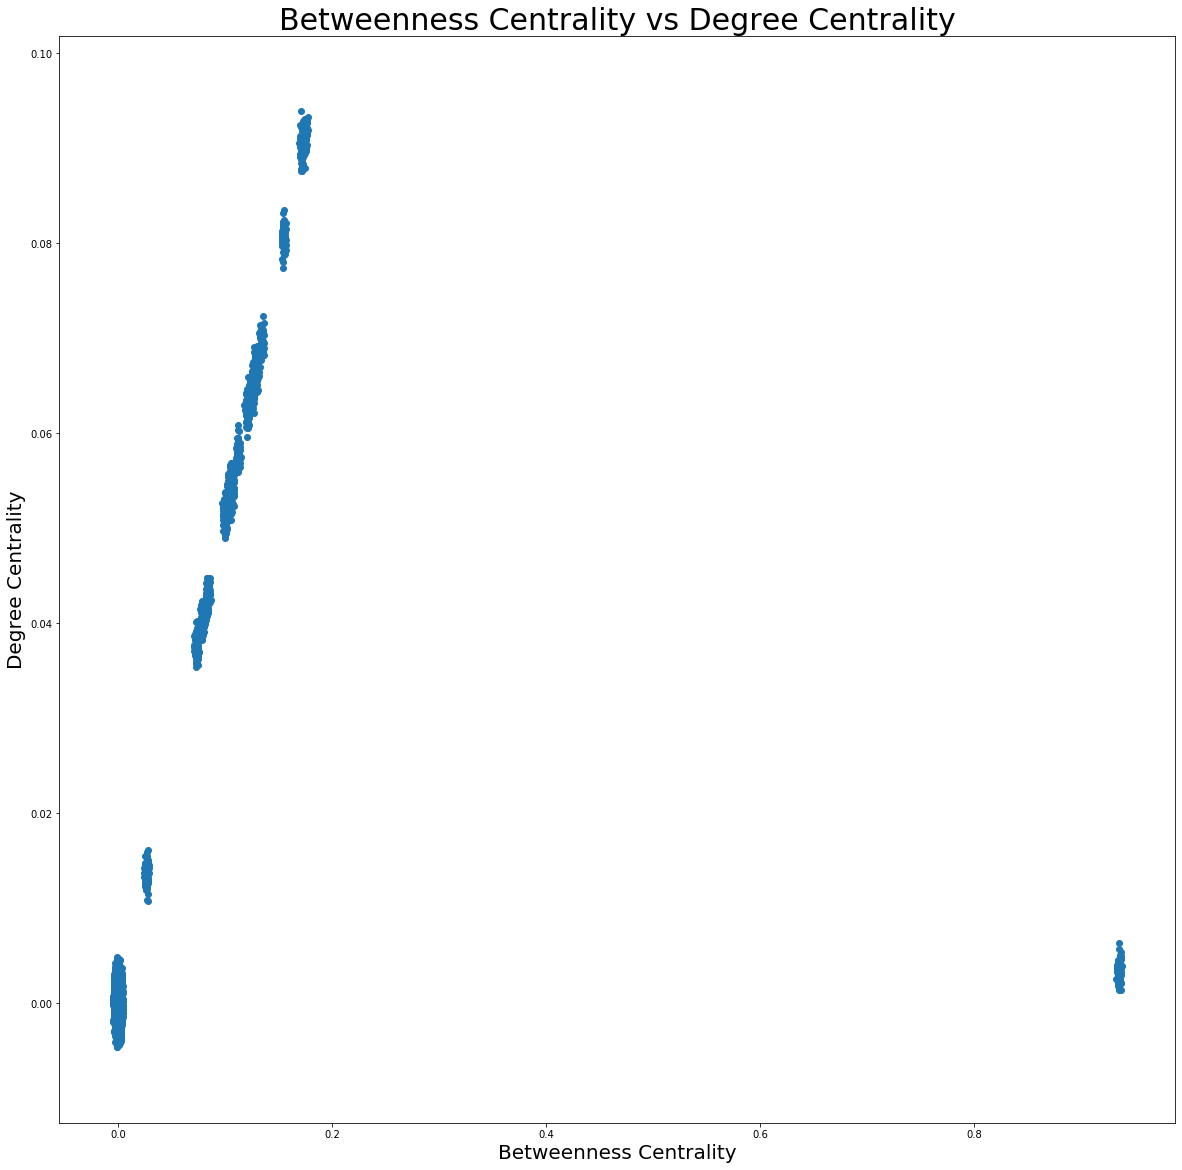

In [142]:
# Compute the betweenness centrality of G: bet_cen, add jitter function
bet_cen = nx.betweenness_centrality(G)
list_bc = list(bet_cen.values())
list_bc2 = [x+(.001*np.random.randn(100)) for x in list_bc]

# Compute the degree centrality of G: deg_cen, add jitter function
deg_cen = nx.degree_centrality(G)
list_dc = list(deg_cen.values())
list_dc2 = [x+(.001*np.random.randn(100)) for x in list_dc]

# Display the plot
plt.figure(figsize = (20,20))

# Create a scatter plot of betweenness centrality and degree centrality
plt.scatter(list_bc2, list_dc2)

ax = fig.add_subplot(111)
plt.title('Betweenness Centrality vs Degree Centrality',fontsize=30)
plt.xlabel('Betweenness Centrality',fontsize=20)
plt.ylabel('Degree Centrality',fontsize=20)
plt.show()

Since betweenness centrality for each node represents the number of shortest paths that pass through the node, it makes sense that our network graph has few nodes with betweenness of 1.0; as shown in the plot above, other nodes cluster between 0 and approximately 0.2. Degree centrality ranges from 0.0 to 0.10; with our undirected graph, the vast majority of the sample are followers with no connections (in our graph) other than the 18 users we chose as followers of @mikegravel.

### Eigenvector Centrality

In [143]:
G_dict3 = dict(nx.eigenvector_centrality_numpy(G))
ordered_G3 = sorted(G_dict3, key = G_dict3.get,reverse = True)

print("Top 10, eigenvector centrality:")

for i in range(10):
    print(ordered_G3[i])
    
print("\n")

Top 10, eigenvector centrality:
helloise7
tucsonmike
mikegravel
badjieablie
veillifting
lcaselalouis
honordsr
samueldeckert
wendymeer11
budgothmog44




In [144]:
eigen = pd.DataFrame(G_dict3,index=['eigen']).T
#print(['%s %0.2f'%(node,between[node]) for node in between])

nodeinfo = nodeinfo.merge(eigen, left_index=True, right_index=True, how='inner')

nodeinfo.head(15)

followers_count    log_fc verified   between    degree  \
mikegravel                   NaN       NaN      NaN  0.935391  0.003276   
mslizclementine              5.0  1.609438    False  0.000000  0.000106   
thesecondgoing            2013.0  7.607381    False  0.128935  0.066793   
bosnaireland               501.0  6.216606    False  0.000000  0.000106   
kateah                    1625.0  7.393263    False  0.103900  0.053477   
nymediacritic              501.0  6.216606    False  0.000000  0.000106   
acttogetherfl             2381.0  7.775276    False  0.120827  0.062460   
hollis517                  501.0  6.216606    False  0.000000  0.000106   
ajfeather                 1542.0  7.340836    False  0.127751  0.066159   
dennisbright12             501.0  6.216606    False  0.000000  0.000106   
dmarkscohen                501.0  6.216606    False  0.000000  0.000106   
politicutie                939.0  6.844815    False  0.078712  0.040266   
vonnegutterball            501.0  6.216606    False  0.000000  0.000106   
nelson_nec_                502.0  6.218600    False  0.000000  0.000106   
oshiserves                 929.0  6.834109    False  0.099893  0.051363   

                    eigen  
mikegravel       0.027375  
mslizclementine  0.000929  
thesecondgoing   0.003389  
bosnaireland     0.000115  
kateah           0.002216  
nymediacritic    0.000075  
acttogetherfl    0.002891  
hollis517        0.000098  
ajfeather        0.003306  
dennisbright12   0.000112  
dmarkscohen      0.000929  
politicutie      0.001650  
vonnegutterball  0.000056  
nelson_nec_      0.000112  
oshiserves       0.002101

### PageRank

In [145]:
G_dict4 = dict(nx.pagerank(G))
ordered_G4 = sorted(G_dict4, key = G_dict4.get,reverse = True)

print("Top 10, PageRank:")

for i in range(10):
    print(ordered_G4[i])
    
print("\n")

Top 10, PageRank:
helloise7
tucsonmike
robyn459
kimfinnie
thesecondgoing
ajfeather
zacharywelliott
acttogetherfl
goddessmasha
jarongubernick




In [146]:
pagerank = pd.DataFrame(G_dict4,index=['pagerank']).T
#print(['%s %0.2f'%(node,between[node]) for node in between])

nodeinfo = nodeinfo.merge(pagerank, left_index=True, right_index=True, how='inner')

nodeinfo.head(15)

followers_count    log_fc verified   between    degree  \
mikegravel                   NaN       NaN      NaN  0.935391  0.003276   
mslizclementine              5.0  1.609438    False  0.000000  0.000106   
thesecondgoing            2013.0  7.607381    False  0.128935  0.066793   
bosnaireland               501.0  6.216606    False  0.000000  0.000106   
kateah                    1625.0  7.393263    False  0.103900  0.053477   
nymediacritic              501.0  6.216606    False  0.000000  0.000106   
acttogetherfl             2381.0  7.775276    False  0.120827  0.062460   
hollis517                  501.0  6.216606    False  0.000000  0.000106   
ajfeather                 1542.0  7.340836    False  0.127751  0.066159   
dennisbright12             501.0  6.216606    False  0.000000  0.000106   
dmarkscohen                501.0  6.216606    False  0.000000  0.000106   
politicutie                939.0  6.844815    False  0.078712  0.040266   
vonnegutterball            501.0  6.216606    False  0.000000  0.000106   
nelson_nec_                502.0  6.218600    False  0.000000  0.000106   
oshiserves                 929.0  6.834109    False  0.099893  0.051363   

                    eigen  pagerank  
mikegravel       0.027375  0.001339  
mslizclementine  0.000929  0.000053  
thesecondgoing   0.003389  0.030844  
bosnaireland     0.000115  0.000057  
kateah           0.002216  0.024697  
nymediacritic    0.000075  0.000057  
acttogetherfl    0.002891  0.028844  
hollis517        0.000098  0.000057  
ajfeather        0.003306  0.030551  
dennisbright12   0.000112  0.000057  
dmarkscohen      0.000929  0.000053  
politicutie      0.001650  0.018600  
vonnegutterball  0.000056  0.000057  
nelson_nec_      0.000112  0.000057  
oshiserves       0.002101  0.023722

### Centrality Comparision by Verified User Status

Twitter users can apply for a "verified" status, meaning that Twitter has vetted that the person is (in real life) who they say they are in their Twitter username.

Someone who takes the time to acquire verified status might also have higher centrality--but do they?

We will find out by comparing average centrality as measured by betweenness and average degree connectivity.

Count how many are verified:

In [15]:
master1.groupby('verified').count()[['screen_name']]

screen_name
verified             
False            9014
True              448

Using the dataframe created above, we'll compare the centrality measures among verified and unverified users. First, we'll set @mikegravel's status as verified and his follower count at 97,198. Then we'll calculate the log of his follower count to make the data complete. 

In [148]:
nodeinfo.at['mikegravel', 'verified'] = True
nodeinfo.at['mikegravel', 'followers_count'] = 97198
nodeinfo.at['mikegravel', 'log_fc'] = np.log(97198)
nodeinfo.head(15)

followers_count     log_fc verified   between    degree  \
mikegravel               97198.0  11.484505     True  0.935391  0.003276   
mslizclementine              5.0   1.609438    False  0.000000  0.000106   
thesecondgoing            2013.0   7.607381    False  0.128935  0.066793   
bosnaireland               501.0   6.216606    False  0.000000  0.000106   
kateah                    1625.0   7.393263    False  0.103900  0.053477   
nymediacritic              501.0   6.216606    False  0.000000  0.000106   
acttogetherfl             2381.0   7.775276    False  0.120827  0.062460   
hollis517                  501.0   6.216606    False  0.000000  0.000106   
ajfeather                 1542.0   7.340836    False  0.127751  0.066159   
dennisbright12             501.0   6.216606    False  0.000000  0.000106   
dmarkscohen                501.0   6.216606    False  0.000000  0.000106   
politicutie                939.0   6.844815    False  0.078712  0.040266   
vonnegutterball            501.0   6.216606    False  0.000000  0.000106   
nelson_nec_                502.0   6.218600    False  0.000000  0.000106   
oshiserves                 929.0   6.834109    False  0.099893  0.051363   

                    eigen  pagerank  
mikegravel       0.027375  0.001339  
mslizclementine  0.000929  0.000053  
thesecondgoing   0.003389  0.030844  
bosnaireland     0.000115  0.000057  
kateah           0.002216  0.024697  
nymediacritic    0.000075  0.000057  
acttogetherfl    0.002891  0.028844  
hollis517        0.000098  0.000057  
ajfeather        0.003306  0.030551  
dennisbright12   0.000112  0.000057  
dmarkscohen      0.000929  0.000053  
politicutie      0.001650  0.018600  
vonnegutterball  0.000056  0.000057  
nelson_nec_      0.000112  0.000057  
oshiserves       0.002101  0.023722

### T-Tests, Independent Samples  

Using functions within `scipy`, t-tests were conducted on 4 metrics calculated above: betweenness centrality, degree centrality, eigenvector centrality, and pagerank. Equal variance is not assumed.

In [149]:
import scipy
from scipy import stats

sample1 = nodeinfo[(nodeinfo['verified']==True)]
sample2 = nodeinfo[(nodeinfo['verified']==False)]

sample1.head(5)

followers_count     log_fc verified   between    degree  \
mikegravel              97198.0  11.484505     True  0.935391  0.003276   
tankcat                  5183.0   8.553139     True  0.083778  0.042908   
bobrackleff               508.0   6.230481     True  0.000000  0.000106   
colemanfortn32            587.0   6.375025     True  0.000000  0.000106   
spencer_wnews             661.0   6.493754     True  0.000000  0.000106   

                   eigen  pagerank  
mikegravel      0.027375  0.001339  
tankcat         0.001739  0.019819  
bobrackleff     0.000098  0.000057  
colemanfortn32  0.000098  0.000057  
spencer_wnews   0.000112  0.000057

In [150]:
sample2.head(5)

followers_count    log_fc verified   between    degree  \
mslizclementine              5.0  1.609438    False  0.000000  0.000106   
thesecondgoing            2013.0  7.607381    False  0.128935  0.066793   
bosnaireland               501.0  6.216606    False  0.000000  0.000106   
kateah                    1625.0  7.393263    False  0.103900  0.053477   
nymediacritic              501.0  6.216606    False  0.000000  0.000106   

                    eigen  pagerank  
mslizclementine  0.000929  0.000053  
thesecondgoing   0.003389  0.030844  
bosnaireland     0.000115  0.000057  
kateah           0.002216  0.024697  
nymediacritic    0.000075  0.000057

In [180]:
scipy.stats.levene(sample1['between'], sample2['between'])

LeveneResult(statistic=15.508591584838472, pvalue=8.272046978013483e-05)

In [189]:
scipy.stats.ttest_ind(sample1['between'], sample2['between'], equal_var=False, nan_policy='omit')

Ttest_indResult(statistic=0.9872200228348627, pvalue=0.32406696202410434)

Levene's test reveals that equal variances may not be assumed; there is no statistically significant difference in betweenness centrality among the two groups.

In [182]:
scipy.stats.levene(sample1['degree'], sample2['degree'])

LeveneResult(statistic=0.0007418044428389879, pvalue=0.9782720074365604)

In [184]:
scipy.stats.ttest_ind(sample1['degree'], sample2['degree'], equal_var=True, nan_policy='omit')

Ttest_indResult(statistic=-0.027236087142595004, pvalue=0.978272007434442)

Equal variances are indicated by a LEvene test; there is no significant difference in degree centrality among the two groups.

In [185]:
scipy.stats.levene(sample1['eigen'], sample2['eigen'])

LeveneResult(statistic=16.70428202018132, pvalue=4.4043232338916517e-05)

In [190]:
scipy.stats.ttest_ind(sample1['eigen'], sample2['eigen'], equal_var=False, nan_policy='omit')

Ttest_indResult(statistic=-11.030017618911707, pvalue=7.121222414909436e-27)

With no equal variances assumed, there is a statistically significant difference in eigenvector centrality among verified and unverified users.

In [187]:
scipy.stats.levene(sample1['pagerank'], sample2['pagerank'])

LeveneResult(statistic=0.0011726252774838634, pvalue=0.9726836082934437)

In [188]:
scipy.stats.ttest_ind(sample1['pagerank'], sample2['pagerank'], equal_var=True, nan_policy='omit')

Ttest_indResult(statistic=-0.03401217970141057, pvalue=0.9728681558252457)

With equal variances assumed there is no significant difference in pagerank.

The t-tests above indicate statistically significant differences in eigenvector centrality, indicating that verified status is associated with higher metrics of network influence in our sample. While there was no significant difference in betweenness centrality, degree centrality or pagerank among verified users and unverified users, this is most likely due to sample composition. If time allowed, a larger sample size composed of more tiers of followers would yield different results.

Means for each group are calculated below.

### Means, Verified and Unverified

In [178]:
cen_res = pd.DataFrame(np.array([['verified',
                                  np.mean(sample1['between']),
                                  np.mean(sample1['degree']),
                                  np.mean(sample1['eigen']),
                                  np.mean(sample1['pagerank'])],
                                 ['unverified',np.mean(sample2['between']),np.mean(sample2['degree']),
                                  np.mean(sample2['eigen']),np.mean(sample2['pagerank'])]]),
                                 columns=['user','between', 'degree', 'eigen','pagerank'])

cen_res

user                 between                  degree  \
0    verified    0.002269863432616525  0.00020807647422417479   
1  unverified  0.00020471169216726504  0.00021151249867686406   

                   eigen                pagerank  
0  0.0006326404391564716  0.00010378783975686557  
1  0.0026064457829947105  0.00010576872198237527

### Betweenness, Average Degree Connectivity for Subset Networks  

In order to further examine the differences between verified and unverified users, we calculated betweenness and average degree connectivity in subset networks composed entirely of verified or unverified users.

In [155]:
verified_df = master1[master1['verified'] == True] #filter by verification status
unverified_df = master1[master1['verified'] == False]

In [156]:
G_verified = nx.from_pandas_edgelist(verified_df, 'source', 'screen_name')
G_unverified = nx.from_pandas_edgelist(unverified_df, 'source', 'screen_name')

In [157]:
def avg_bet_cent(G):
    bet_cen = nx.betweenness_centrality(G)
    list_bc = list(bet_cen.values())
    avg_bet = np.average(list_bc)
    return avg_bet

def overall_average_deg_connect(G):
    avg_dc = nx.average_degree_connectivity(G)
    list_adc = list(avg_dc.values())
    overall_avg = np.average(list_adc)
    return overall_avg

In [158]:
avg_bet_cent_v = avg_bet_cent(G_verified)
print(avg_bet_cent_v)

avg_bet_cent_u = avg_bet_cent(G_unverified)
print(avg_bet_cent_u)

0.00018971563476256716
0.0002918397514751155


In [159]:
overall_avg_deg_v = overall_average_deg_connect(G_verified)
print(overall_avg_deg_v)

overall_avg_deg__u = overall_average_deg_connect(G_unverified)
print(overall_avg_deg__u)


4.021683673469388
47.042893628610706


## Conclusion

Verified status in Twitter is associated with higher eigenvector centrality in our sample. Though we found no statistically significant differences in the betweenness centrality or degree centrality among verified and unverified users in our plotted network nodes, experimentation with sample size and composition would likely change this result. According to these analyses, verified status does indeed indicate higher degrees of influence within our network.

While the betweenness centrality for the network of unverified users is approximately equal to that of the network of verified users, the overall average degree connectivity of the unverified users network is much higher! This latter fact *may* be an artifact of the data sampling. It is interesting to note that the verified users seem much more likely to be a node in between--perhaps reflecting that they are more trusted within the network. Given that fact, it may make sense for the campaign to target verified Twitter users to broadcast their message to more groups.

## Resources:  
- DataCamp NetworkX Python Graph Tutorial (https://www.datacamp.com/community/tutorials/networkx-python-graph-tutorial)

- [Python Graph Gallery](https://python-graph-gallery.com/324-map-a-color-to-network-nodes/)

- [University of Cambridge: Network Analysis with Python](https://www.cl.cam.ac.uk/teaching/1314/L109/tutorial.pdf)

- [Medium: Visualising Twitter Interaction with NetworkX](https://medium.com/future-vision/visualizing-twitter-interactions-with-networkx-a391da239af5)

- [Interaction Network](https://github.com/ugis22/analysing_twitter/blob/master/Jupyter%20Notebook%20files/Interaction%20Network.ipynb)

- [NetworkkX Documentation](https://networkx.github.io/documentation/stable/reference/algorithms/centrality.html)

- [Stack Overflow: NetworkX Degree Centrality](https://stackoverflow.com/questions/50241195/networkx-degree-centrality)

- Twitter API access code adapted from: [Stack Abuse](https://stackabuse.com/accessing-the-twitter-api-with-python/)

- Stack Overflow:[How to iterate through a nested dictionary](https://stackoverflow.com/questions/43752962/how-to-iterate-through-a-nested-dict/43753431)

- [How to Get a User List Using Twython](https://www.silkstream.net/blog/2014/06/playing-with-followers-with-twython-csv.html)

- [NetworkX Tutorial](https://networkx.github.io/documentation/stable/tutorial.html)